In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import sys
import math
import os
import numpy as np
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

# local code
sys.path.insert(1, "./code/")
from Utils import Utils # student's library
from Eval import Eval # student's library
from Extract import Extract # student's library


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peterkong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [3]:
# sanity checks
#train_df.id.nunique()
# 19579

#train_df.author.unique()
# array(['EAP', 'HPL', 'MWS'], dtype=object)

In [4]:
Utils.check_for_nulls(train_df)

{'author': 0, 'id': 0, 'text': 0}

In [6]:
# splitting data

# regular data
#     train: 19580 * .9 rows
#     test:  8393 rows
#     val:   19580 * .1 rows


if os.path.isfile('data/traindata.pickle'):
    traindata = pd.read_pickle('data/traindata.pickle')
    valdata   = pd.read_pickle('data/valdata.pickle')
    testdata  = pd.read_pickle('data/testdata.pickle')
else: 
    VAL_IDX  = math.ceil(len(train_df) * .8)
    TEST_IDX = math.ceil(len(train_df) * .9)

    traindata = train_df[:VAL_IDX]
    valdata   = train_df[VAL_IDX:TEST_IDX]
    testdata  = train_df[TEST_IDX:]

    print(VAL_IDX, TEST_IDX)

    traindata.to_pickle('data/traindata.pickle')
    valdata.to_pickle('data/valdata.pickle')
    testdata.to_pickle('data/testdata.pickle')

In [7]:
print("traindata: {}, valdata: {}, testdata: {}".format(len(traindata), len(valdata), len(testdata)))

traindata: 15664, valdata: 1958, testdata: 1957


# Feature engineering

In [8]:
# grammatical feature engineering 
# we want to include stopwords here

if os.path.isfile('data/train_gram_feats.pickle'):
    print("reading gram feats from pickle")
    train_gram_feats_df = pd.read_pickle('data/train_gram_feats_df.pickle')
    val_gram_feats_df   = pd.read_pickle('data/val_gram_feats_df.pickle')
    test_gram_feats_df  = pd.read_pickle('data/test_gram_feats_df.pickle')
else:
    seq_no = None
    train_gram_feats_df = Extract.gram_feats(traindata.text, None, seq_no)

    # need to remember so that val/test process
    # does not add additional columns
    GRAM_FEAT_LIST = list(train_gram_feats_df.columns)

    val_gram_feats_df = Extract.gram_feats(valdata.text, GRAM_FEAT_LIST, seq_no)
    test_gram_feats_df = Extract.gram_feats(testdata.text, GRAM_FEAT_LIST, seq_no)

    # there are 21 columns excluding sequence columns 
    # 7ary sequence columns can generate up to 2187
    
    train_gram_feats_df.to_pickle('data/train_gram_feats_df.pickle')
    val_gram_feats_df.to_pickle('data/val_gram_feats_df.pickle')
    test_gram_feats_df.to_pickle('data/test_gram_feats_df.pickle')    


In [9]:
# removes a singleton feature
for df in train_gram_feats_df, val_gram_feats_df, test_gram_feats_df:
    if 'SYM_count' in list(df.columns):
        df.drop('SYM_count', axis=1, inplace=True)
        
print(train_gram_feats_df.shape)
print(val_gram_feats_df.shape)
print(test_gram_feats_df.shape)

#set(GRAM_FEAT_LIST) - set(list(val_gram_feats_df.columns))

(15664, 23)
(1958, 23)
(1957, 23)


In [113]:
# textual feature engineering
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=STOPWORDS, max_features=1500)

train_text_feats = vectorizer.fit_transform(traindata.text)
Y_train = traindata.author 

val_text_feats = vectorizer.transform(valdata.text) 
Y_val = list(valdata.author)

test_text_feats = vectorizer.transform(testdata.text) 
Y_test = list(testdata.author)



In [114]:
#convert text feats to pandas

cols = ["text_" + str(x) for x in range(train_text_feats.shape[1])]

train_text_feats_df = pd.DataFrame(train_text_feats.todense(), index=None, columns=cols)
val_text_feats_df = pd.DataFrame(val_text_feats.todense(), index=None, columns=cols)
test_text_feats_df = pd.DataFrame(test_text_feats.todense(), index=None, columns=cols)

print(train_text_feats_df.shape)
print(val_text_feats_df.shape)
print(test_text_feats_df.shape)


(15664, 1500)
(1958, 1500)
(1957, 1500)


In [66]:
# persist to disk
if not os.path.isfile('data/train_text_feats_df.pickle'):
    train_text_feats_df.to_pickle('data/train_text_feats_df.pickle')
    val_text_feats_df.to_pickle('data/val_text_feats_df.pickle')
    test_text_feats_df.to_pickle('data/test_text_feats_df.pickle')  

In [97]:
train_text_feats_df.head()

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,...,text_590,text_591,text_592,text_593,text_594,text_595,text_596,text_597,text_598,text_599
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.293483,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.263912,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [117]:
# gensim feature engineering
import numpy as np
import gensim
GENSIM = True

if GENSIM:

    #https://radimrehurek.com/gensim/models/doc2vec.html
    from gensim.test.utils import common_texts
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument
    #TaggedDocument does not filter or stem

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(X_val.text))]
    model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

    train_gensim = np.array([model.infer_vector(x) for x in list(X_train.text)])
    val_gensim = np.array([model.infer_vector(x) for x in list(X_val.text)])
    test_gensim = np.array([model.infer_vector(x) for x in list(X_test.text)])

    # numpy to pandas
    cols = ["gensim_" + str(x) for x in range(len(train_gensim[0]))]

    X_train = pd.DataFrame(train_gensim, index=None, columns=cols)
    X_val = pd.DataFrame(val_gensim, index=None, columns=cols)
    X_test = pd.DataFrame(test_gensim, index=None, columns=cols)
    
# gensim didn't help. so we're settling on tfidf extual features for now, and will explore neural models


AttributeError: 'DataFrame' object has no attribute 'text'

In [115]:
# concatenating features

    #traindata.text.to_frame() for gensim
    #val_gram_feats_df.fillna(0)
X_train = train_text_feats_df.fillna(0)
X_val = val_text_feats_df.fillna(0)
X_test = test_text_feats_df.fillna(0)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(15664, 1500)
(1958, 1500)
(1957, 1500)


In [70]:
#df = pd.DataFrame({'foo':[1,3,99], 'bar':[2,4,7]})

def transform(df):
    def xform(x, **kwargs):
        return (x - avg) / stdv

    for col in df.columns:
        stdv = df[col].std()
        avg = df[col].mean()
        df[col] = df[col].apply(xform, avg=avg, stdv=stdv)
        
    return df

In [71]:
# this cell throws on non numerical columns

# X_train = transform(X_train).fillna(0)
# X_val = transform(X_val).fillna(0)
# X_test = transform(X_test).fillna(0)

# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

In [72]:
#sanity checking
assert(list(X_train.columns) == list(X_val.columns))
assert(list(X_train.columns) == list(X_test.columns))

# Exploration

In [119]:
# lex = Utils.build_lexicon(traindata.text, STOPWORDS)
# len(lex)

# 22847 different tokens in full lexicon

22947

In [73]:
mws_df = train_df[train_df.author == 'MWS']
hpl_df = train_df[train_df.author == 'HPL']
eap_df = train_df[train_df.author == 'EAP']

cutoff = min([mws_df.shape[0], hpl_df.shape[0], eap_df.shape[0]])

# equalize corpus sizes to avoid bias during exploration
mws_df = mws_df[:cutoff]
hpl_df = hpl_df[:cutoff]
eap_df = eap_df[:cutoff]

mws_lexicon = Utils.build_lexicon(mws_df.text, STOPWORDS)
hpl_lexicon = Utils.build_lexicon(hpl_df.text, STOPWORDS)
eap_lexicon = Utils.build_lexicon(eap_df.text, STOPWORDS)

# sanity check
assert(cutoff * 3 == len(mws_df) + len(hpl_df) + len(eap_df))

# add grammatical features (for exploration this time, not training)
mws_gram_feats_df = Extract.gram_feats(mws_df.text, None, None)
hpl_gram_feats_df = Extract.gram_feats(hpl_df.text, None, None)
eap_gram_feats_df = Extract.gram_feats(eap_df.text, None, None)

mws_gram_feats_df.describe()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
count,5635.000000,5204.000000,5635.000000,4003.000000,4863.000000,183.000000,5635.000000,543.000000,2256.000000,4732.000000,...,20.000000,5635.000000,5635.000000,5635.0,5635.000000,5635.0,5635.0,5635.000000,5635.000000,5635.000000
mean,3.554392,4.177364,1.587400,1.880839,3.082459,1.169399,5.607986,1.206262,1.435284,2.749155,...,1.200000,1.656980,2.367340,0.0,0.057675,0.0,0.0,0.080213,0.442413,151.974800
std,3.675758,3.799392,1.814904,1.305063,2.880091,0.627872,5.432861,0.524138,0.867382,2.506438,...,0.695852,1.338079,2.417259,0.0,0.258424,0.0,0.0,0.382373,0.750584,128.698383
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,21.000000
25%,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,84.000000
50%,3.000000,3.000000,1.000000,2.000000,2.000000,1.000000,5.000000,1.000000,1.000000,2.000000,...,1.000000,1.400000,2.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,129.000000
75%,5.000000,5.000000,2.000000,2.000000,4.000000,1.000000,7.000000,1.000000,2.000000,4.000000,...,1.000000,2.000000,3.500000,0.0,0.000000,0.0,0.0,0.000000,1.000000,192.000000
max,116.000000,130.000000,41.000000,27.000000,96.000000,6.000000,193.000000,5.000000,17.000000,64.000000,...,4.000000,14.000000,18.000000,0.0,3.000000,0.0,0.0,10.000000,6.000000,4663.000000


In [74]:
# looks like sentence length values are consistently higher by at least a degree of magnitude
# so we'll take the log
for df in [mws_gram_feats_df, hpl_gram_feats_df, eap_gram_feats_df]:
    df['sent_len'] = df['sent_len'].apply(lambda x: math.log(x))
    df.rename(inplace=True, columns={'sent_len': 'log_sent_len'})


In [75]:
# NER exploration

# avoiding NER for three reasons:
# features very sparse
# features seem content-specific, so may contribute to misprediction
# should we add data from the same authors about other topics

NER = False
if NER:
    import spacy
    spacy_mdl = spacy.load('en_core_web_sm')

    def sent_to_ents(sent, spacy):
        sent = spacy(sent)
        ents = []
        for ent in sent.ents:
            ents.append(ent.text + ':' + ent.label_)
        return ents

    entities = []
    for i in range(1500):
        sent = valdata.iloc[i].text
        ents = sent_to_ents(sent, spacy_mdl)
        entities.append(ents)
 

# example entities list HERE
# many sentences don't have any entities, like below
#'In whatever way the shifting is managed, it is of course concealed at every step from observation.'

In [76]:
if NER:
    import statistics as stat
    entity_freq = [len(x) for x in entities]


    print("stats for NER within a sample group: \n")
    print("min: {} \nmax: {} \nmean: {} \nstdev: {}" \
          .format(min(entity_freq), max(entity_freq), stat.mean(entity_freq), stat.stdev(entity_freq)))



# Exploration - visualization

In [77]:
# data viz

def plot_word_freq(lexicon, name, quantity=20):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    elems = [x[0] for x in lexicon[:quantity]]
    y_pos = np.arange(quantity)
    vals = [x[1] for x in lexicon[:quantity]]

    ax.barh(y_pos, vals, align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(elems)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Corpus-wide frequency')
    ax.set_title(name + ' - Word Frequencies')

    plt.show()
 
authors = {'MWS': mws_lexicon, 'HPL': hpl_lexicon, 'EAP': eap_lexicon}

pd.set_option('display.max_colwidth', -1)
print("Example MWS sentence: \n{}\n".format(mws_df.text[:1].to_string()))
print("Example HPL sentence: \n{}\n".format(hpl_df.text[:1].to_string()))
print("Example EAP sentence: \n{}\n".format(eap_df.text[:1].to_string()))
pd.set_option('display.max_colwidth', 80)

# for key in authors: 
#     plot_word_freq(authors[key], key)


Example MWS sentence: 
3    How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.

Example HPL sentence: 
1    It never once occurred to me that the fumbling might be a mere mistake.

Example EAP sentence: 
0    This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.



In [78]:
def plot_box(df, subset):
    features = {
        'tag_features': [
             'ADJ_count',
             'ADP_count',
             'ADV_count',
             'CCONJ_count',
             'DET_count',
             'NOUN_count',
             'PRON_count',
             'VERB_count'],
        'punc_features': [
            'bang_count',
            'colon_count',
            'ellipse_count',
            'lparen_count',
            'quote_count',
            'semicolon_count'],
        'ratio_features': [
             'adj_noun_ratio',
             'adv_verb_ratio',
             'log_sent_len']
    }
    
    fig, ax = plt.subplots()
    boxplot = df.boxplot(column=features[subset], \
        showfliers=False, fontsize=6, figsize=None)
    plt.show()

In [79]:
#plot_box(mws_gram_feats_df, 'ratio_features')

In [80]:
#plot_box(hpl_gram_feats_df, 'ratio_features')

In [81]:
#plot_box(eap_gram_feats_df, 'ratio_features')

In [82]:
#plot_box(mws_gram_feats_df, 'tag_features')

In [83]:
#plot_box(hpl_gram_feats_df, 'tag_features')

In [84]:
#plot_box(eap_gram_feats_df, 'tag_features')

In [85]:
#plot_box(mws_gram_feats_df, 'punc_features')

In [86]:
#plot_box(hpl_gram_feats_df, 'punc_features')

In [87]:
#plot_box(eap_gram_feats_df, 'punc_features')

In [88]:
eap_gram_feats_df.describe()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,log_sent_len
count,5635.000000,5018.000000,5635.000000,3307.000000,5004.000000,173.000000,5635.000000,757.000000,1949.000000,4080.000000,...,92.000000,5635.000000,5635.000000,5635.0,5635.000000,5635.000000,5635.0,5635.000000,5635.000000,5635.000000
mean,2.918012,4.378836,1.936646,1.728152,3.605516,1.439306,5.114286,1.504624,1.420729,2.127696,...,1.989130,1.692336,1.787072,0.0,0.022538,0.011180,0.0,0.165217,0.172671,4.710147
std,2.850061,3.656925,2.000106,1.218010,2.864495,0.995959,4.344305,1.394070,0.765330,1.478494,...,1.558349,1.518619,1.810267,0.0,0.157714,0.361998,0.0,0.790786,0.523666,0.710429
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,3.044522
25%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,0.800000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,4.204693
50%,2.000000,3.000000,1.000000,1.000000,3.000000,1.000000,4.000000,1.000000,1.000000,2.000000,...,1.000000,1.400000,1.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,4.744932
75%,4.000000,6.000000,3.000000,2.000000,5.000000,2.000000,7.000000,2.000000,2.000000,3.000000,...,2.000000,2.125000,2.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,5.220356
max,39.000000,64.000000,19.000000,13.000000,45.000000,8.000000,67.000000,27.000000,8.000000,15.000000,...,9.000000,14.000000,13.000000,0.0,3.000000,17.000000,0.0,23.000000,11.000000,7.334982


In [89]:
# strangely enough, grepping through the raw input indeed shows that no bang characters exist
# the boxplots indicate that the grammatical features indeed don't seem to have much 
# predictive power, so we'll try other features.

# Model selection, training, prediction

In [110]:
def train_n_run(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    lin_clf = LinearSVC()
    lin_clf.fit(X_train, Y_train) 
    
    preds = lin_clf.predict(X_val)
    accuracy = Eval.get_accuracy(preds, Y_val)
    print("Val Accuracy: ", accuracy)
    
    preds = lin_clf.predict(X_test)
    accuracy = Eval.get_accuracy(preds, Y_test)
    print("Test Accuracy: ", accuracy)
    


In [116]:
train_n_run(X_train, Y_train, X_val, Y_val, X_test, Y_test)

Val Accuracy:  0.7318692543411645
Test Accuracy:  0.7199795605518651


In [ ]:
predict()

# Error Analysis

[[579 100  99]
 [219 279  85]
 [270  93 234]]


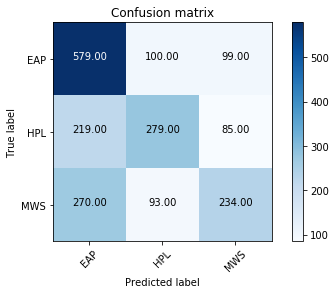

In [91]:
# error analysis
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

conf_mat = confusion_matrix(Y_val, preds)


# NOTE: this function taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = 500
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure()
print(conf_mat)
plot_confusion_matrix(conf_mat, classes=lin_clf.classes_,
                      title="Confusion matrix")
plt.show()

In [92]:
# [good place to insert val vs. test metrics]

In [93]:
import time
timenow = time.asctime( time.localtime(time.time()) )
print("Finished at: ", timenow)

Finished at:  Sun Dec  9 00:18:56 2018
